# Analysing Survey Responses

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

In [157]:
data = pd.read_excel("data/survey_responses.xlsx", sheet_name="all")

In [158]:
data = data.drop('Unnamed: 0', axis=1)

In [159]:
n_rows, n_cols = data.shape

In [160]:
data.head()

,info:0_help,info:1_reason,info:2_adhd,info:3_stress,info_injury:0_injury,pain:0_position,synsskarphed:0_Jeg oplever sløret og uklart syn på lang afstand,synsskarphed:1_Jeg oplever sløret og uklart syn på kort afstand,"synsskarphed:2_Jeg oplever, at skarpheden af synet ændrer sig eller varierer i løbet af dagen",synsskarphed:3_Jeg har dårligt nattesyn,...,rivermead_1_control:6_At være irritabel / bliver nemt vred,rivermead_1_control:7_At føle dig deprimeret eller ked af det,rivermead_2_control:0_At føle dig frustreret eller utålmodig,rivermead_2_control:1_Glemsomhed / dårlig hukommelse,rivermead_2_control:2_Dårlig koncentration,rivermead_2_control:3_At tænke langsommere,rivermead_2_control:4_Sløret syn,"rivermead_2_control:5_Lysfølsomhed, bliver nemt irriteret af skarpt lys",rivermead_2_control:6_At se dobbelt,rivermead_2_control:7_Rastløshed
0,0.0,NaN,1.0,0.0,NaN,[],1.0,4.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,1.0,1.0,0.0,['5'],4.0,0.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,1.0,0.0,3.0,"['0', '1', '2', '4']",0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,1.0,1.0,2.0,['2'],2.0,3.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove all rows that has missing values for all questions.

In [161]:
row_nan_count = data.isna().sum(axis=1)
col_nan_count = data.isna().sum(axis=0)

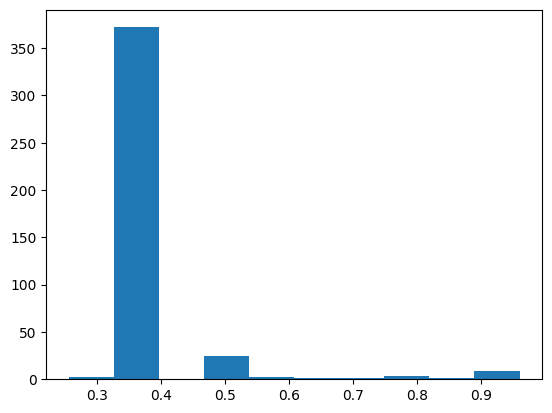

In [162]:
plt.hist(row_nan_count/n_cols);

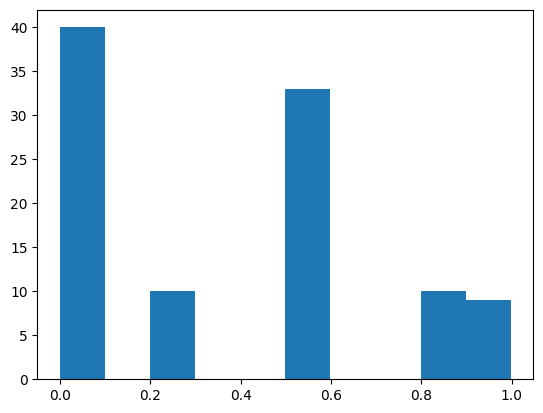

In [163]:
plt.hist(col_nan_count/n_rows);

In [164]:
m = row_nan_count <= round(n_cols*0.60)
data = data[m]

In [165]:
m = col_nan_count <= round(n_rows*0.60)
data = data.loc[:,m]

In [166]:
data.shape

(401, 83)

In [167]:
data.to_excel("data/test.xlsx")

Brug coalesce til at kombinere patient og kontrol spørgsmål fra rivermead.